In [160]:
# pip install librosa

In [161]:
#The output of this section is the CSV files with the data to be handle by the model
CREATE_CSV_FILES = True

In [162]:
# Defines the names of the CSV files
TRAIN_CSV_FILE = "Speaker_Train_File.csv"    # train  60
TEST_CSV_FILE = "Speaker_Test_File.csv"      # test 16

In [163]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
from matplotlib import cm
import pandas as pd
import librosa
import zipfile as zf
import csv
import os
from sklearn import metrics
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import csv
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.mixture import GaussianMixture

In [164]:
def extractWavFeatures(soundFilesFolder, csvFileName):
    print("The features of the files in the folder "+soundFilesFolder+" will be saved to "+csvFileName)
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'  
    for i in range(1, 41):
        header += f' mfcc{i}'  #making headers of csv file
    header += ' label'     
    header = header.split()
    print('CSV Header: ', header)
    file = open(csvFileName, 'w', newline='')
    #with file:
    writer = csv.writer(file)
    writer.writerow(header)
    for filename in os.listdir(soundFilesFolder):
        if filename.endswith('.wav'):
            number = f'{soundFilesFolder}/{filename}'
            y, sr = librosa.load(number, mono=True, duration=30)
            # remove leading and trailing silence
            y, index = librosa.effects.trim(y)
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            rmse = librosa.feature.rms(y=y)
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc = 40)
            to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            writer.writerow(to_append.split())
    file.close()
    print("End of extractWavFeatures")

In [249]:
if (CREATE_CSV_FILES == True):
    extractWavFeatures("Speaker_Train_Data", TRAIN_CSV_FILE)
    extractWavFeatures("Speaker_Test_Data", TEST_CSV_FILE)
    print("CSV files are created")
else:
    print("CSV files creation is skipped")

The features of the files in the folder Speaker_Train_Data will be saved to Speaker_Train_File.csv
CSV Header:  ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'mfcc21', 'mfcc22', 'mfcc23', 'mfcc24', 'mfcc25', 'mfcc26', 'mfcc27', 'mfcc28', 'mfcc29', 'mfcc30', 'mfcc31', 'mfcc32', 'mfcc33', 'mfcc34', 'mfcc35', 'mfcc36', 'mfcc37', 'mfcc38', 'mfcc39', 'mfcc40', 'label']
End of extractWavFeatures
The features of the files in the folder Speaker_Test_Data will be saved to Speaker_Test_File.csv
CSV Header:  ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14

In [250]:
#Reading a dataset and convert file name to corresbonding umnber
def preProcessData(csvFileName):
    header_name_list = ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'mfcc21', 'mfcc22', 'mfcc23', 'mfcc24', 'mfcc25', 'mfcc26', 'mfcc27', 'mfcc28', 'mfcc29', 'mfcc30', 'mfcc31', 'mfcc32', 'mfcc33', 'mfcc34', 'mfcc35', 'mfcc36', 'mfcc37', 'mfcc38', 'mfcc39', 'mfcc40', 'label']
    print(csvFileName+ " will be preprocessed")
    data =  pd.read_csv(csvFileName)
#     data = pd.read_csv(csvFileName, skiprows=[1, 50]
    # we have 3 speakers: 
    # 0: ahmed
    # 1: belal
    # 2: micheal
    # 3: others
    filenameArray = data['filename'] 
    speakerArray = []
#     print(filenameArray)
    for filename in filenameArray:
        #print(speaker)
        if "ahmed_ashraf" in filename:
            speaker = 0
        elif "Belal" in filename:
            speaker = 1
# #         elif "Micheal" in filename:
#                speaker = "2"
        else: 
            speaker = 3
#         print(speaker)
        speakerArray.append(speaker)
    data['number'] = speakerArray
    #Dropping unnecessary columns
    data = data.drop(['filename'],axis=1)
    data = data.drop(['label'],axis=1)
    data = data.drop(['chroma_stft'],axis=1)
#     data.shape
#     print("Preprocessing is finished")
#     print(data['rmse'])
    print(data)
    return data

In [299]:
trainData = preProcessData(TRAIN_CSV_FILE)
testData = preProcessData(TEST_CSV_FILE)

Speaker_Train_File.csv will be preprocessed
         rmse  spectral_centroid  spectral_bandwidth      rolloff  \
0    0.013404        1288.854671         1518.160524  2435.184420   
1    0.009993        1222.905682         1460.351945  2157.293701   
2    0.017168        1253.064143         1425.561648  2338.823562   
3    0.018104        1198.371032         1500.572803  2209.231086   
4    0.016585        1230.753953         1509.360576  2346.060131   
..        ...                ...                 ...          ...   
266  0.032378        2005.132666         2148.827236  4151.706603   
267  0.036381        1995.008828         2102.141285  3936.269531   
268  0.030267        2145.997022         2248.043801  4451.083646   
269  0.029816        2035.026065         2295.683010  4361.697110   
270  0.030540        1812.283660         2075.019593  3777.220838   

     zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  \
0              0.059564 -505.511658  120.892815  -7.71

In [300]:
testData

,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc32,mfcc33,mfcc34,mfcc35,mfcc36,mfcc37,mfcc38,mfcc39,mfcc40,number
0,0.009993,1222.905682,1460.351945,2157.293701,0.060233,-533.275513,126.323990,-5.393278,7.978744,-1.688960,...,9.847920,6.317571,2.457523,2.565717,-0.549338,-1.875484,-0.544401,-0.735906,-3.623948,3
1,0.016585,1230.753953,1509.360576,2346.060131,0.049973,-485.665253,118.747414,-0.341144,14.197672,-8.606584,...,5.284318,7.979311,1.586594,2.322874,-2.114764,-1.790100,-0.101661,0.374472,-1.964005,3
2,0.013829,1166.165148,1480.120271,2109.620577,0.050800,-504.032043,127.963150,2.349404,14.097299,-8.987041,...,3.478289,7.570534,2.271217,2.971118,0.029042,-0.701853,1.432102,0.208487,-3.162876,3
3,0.015517,1387.471357,1609.152266,2662.320683,0.058013,-501.029175,112.742699,-15.422599,16.566858,-6.766524,...,4.116170,4.058353,1.534295,1.178144,-1.235215,1.639595,-3.728315,-2.688532,-1.636350,3
4,0.015835,1276.583495,1634.214861,2637.144470,0.039693,-499.826416,122.048950,-1.920735,24.336123,-6.788704,...,10.266263,15.390595,9.012878,7.133364,0.400037,-0.292058,-4.085672,0.174606,5.223323,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,0.042985,1814.419202,2068.841427,3832.619167,0.078574,-434.496246,112.916397,14.558284,19.883001,2.654404,...,-2.922314,-5.019325,-4.526140,-4.617517,-4.716003,-5.655179,-4.306020,-4.753742,-3.474115,3
89,0.036381,1995.008828,2102.141285,3936.269531,0.079740,-454.976349,100.731712,16.845055,20.575390,12.396941,...,-4.975369,-5.245577,-4.434406,-6.300651,-4.143828,-4.713008,-3.595579,-6.107916,-2.948173,3
90,0.030267,2145.997022,2248.043801,4451.083646,0.099725,-495.136993,88.907974,21.396997,20.355251,9.377746,...,-5.482361,-4.185727,-4.232754,-5.212183,-2.876807,-3.669876,-4.746403,-4.561175,-1.552745,3
91,0.029816,2035.026065,2295.683010,4361.697110,0.084806,-481.398621,98.354515,25.813599,17.567360,14.787317,...,-3.813303,-4.131896,-3.526616,-5.430199,-3.725750,-3.397746,-3.936089,-5.319873,-2.225244,3


In [301]:
# Splitting the dataset into training, validation and testing dataset

X = trainData[trainData.columns[:-1]]
y = trainData[trainData.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=41 )


# X_test = np.array(testData.iloc[:, :-1], dtype = float)
# y_test = testData.iloc[:, -1]

#X_test = X_val
#y_test = y_val
print("Y from training data:", y_train.shape)
print("Y from validation data:", y_test.shape)
print("Y from test data:", y_test.shape)

Y from training data: (203,)
Y from validation data: (68,)
Y from test data: (68,)


In [302]:
X_train

,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc31,mfcc32,mfcc33,mfcc34,mfcc35,mfcc36,mfcc37,mfcc38,mfcc39,mfcc40
55,0.024999,2503.460795,2973.821914,6229.841044,0.078254,-448.597290,83.529442,40.187492,16.657621,16.291315,...,0.586776,-1.619081,-0.526343,0.917234,-3.375823,0.165110,-1.540859,-0.165943,-0.249635,-1.409111
57,0.028864,2298.275488,2845.040979,5544.201660,0.074278,-449.703979,86.423630,38.443115,16.035173,17.614784,...,1.230914,-0.797705,-1.316740,1.867530,-2.689126,1.045697,-2.285363,-0.912237,-0.209171,-0.931579
140,0.014143,1427.034061,1492.463529,2642.148774,0.108662,-469.166412,133.416962,-10.575525,12.060142,-6.003181,...,-3.189641,-5.211101,-4.154834,-5.776696,-9.460485,-4.663477,-2.266318,-4.926474,-3.369206,-1.857005
38,0.025713,2390.037705,3036.231384,6343.228310,0.066657,-439.655060,89.025719,28.392653,12.432586,27.985111,...,-1.957837,0.322891,-2.328620,0.947204,-2.899705,-0.862109,-3.544873,0.984738,-2.584112,-1.575887
177,0.017189,1700.697660,1646.140497,3177.261247,0.126061,-459.083923,128.839096,-12.514090,18.079603,-16.330599,...,-5.928830,-4.930229,-5.532927,-3.031838,-5.040441,-5.530929,-2.677087,-4.643160,-3.418590,-3.041193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,0.016068,1503.762205,1491.774050,2915.273943,0.119382,-488.015717,118.642868,-9.667338,6.465746,-0.585677,...,-2.035822,-5.822832,-6.327466,-4.924463,-6.990630,-2.573243,-4.602114,-4.734570,-1.120216,-2.516969
236,0.012819,3816.063033,2241.781503,5767.345459,0.333442,-582.650330,63.016846,23.044041,12.047802,0.318819,...,-3.445109,-1.663051,-2.741946,-3.840595,-4.013970,-3.083132,-4.375726,-2.718411,-3.195312,-3.239127
89,0.013133,1470.952944,1691.140734,2899.633789,0.063833,-488.245178,107.129128,-10.445322,20.420298,1.112351,...,9.746824,11.980609,10.496756,4.423410,8.316208,4.051384,2.522376,0.640465,2.014617,2.680758
243,0.016650,2810.445682,2013.141684,4332.448802,0.235502,-536.535156,95.575226,31.877335,16.244364,-0.349099,...,-3.653712,-1.919365,-4.595118,-2.407278,-4.137837,-3.987456,-4.099872,-2.828243,-4.706547,-5.860085


In [303]:
#Normalizing the dataset
from sklearn.preprocessing import StandardScaler, normalize
import numpy as np
#scaler = StandardScaler()
#X_train = scaler.fit_transform( X_train )
#X_test = scaler.transform( X_test )
#X_train = normalize(X_train)
#X_test = normalize (X_test)
print("X from training data", X_train.shape)
print("X from test data", X_test.shape)

X from training data (203, 45)
X from test data (68, 45)


In [304]:

X_train.shape

(203, 45)

In [305]:
# gmm=GaussianMixture(n_components=6, max_iter=200 , covariance_type="diag" , n_init=3)
# gmm.fit(X_train)

In [306]:
#Create an object (model)
dtr1 = DecisionTreeClassifier(max_depth =7, random_state = 10)
#Fit (train) the model

#X_train = X_train.astype('int')

#y_train=y_train.astype('int')


dtr1.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, random_state=10)

In [307]:
np.unique(y_train  ,return_counts = True)


(array([0, 1, 3], dtype=int64), array([ 44,  36, 123], dtype=int64))

In [308]:
np.unique(y_test  ,return_counts = True)


(array([0, 1, 3], dtype=int64), array([13, 14, 41], dtype=int64))

In [309]:
pd.DataFrame(X_train)[pd.DataFrame(X_train).columns[3:9]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203 entries, 55 to 80
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rolloff             203 non-null    float64
 1   zero_crossing_rate  203 non-null    float64
 2   mfcc1               203 non-null    float64
 3   mfcc2               203 non-null    float64
 4   mfcc3               203 non-null    float64
 5   mfcc4               203 non-null    float64
dtypes: float64(6)
memory usage: 11.1 KB


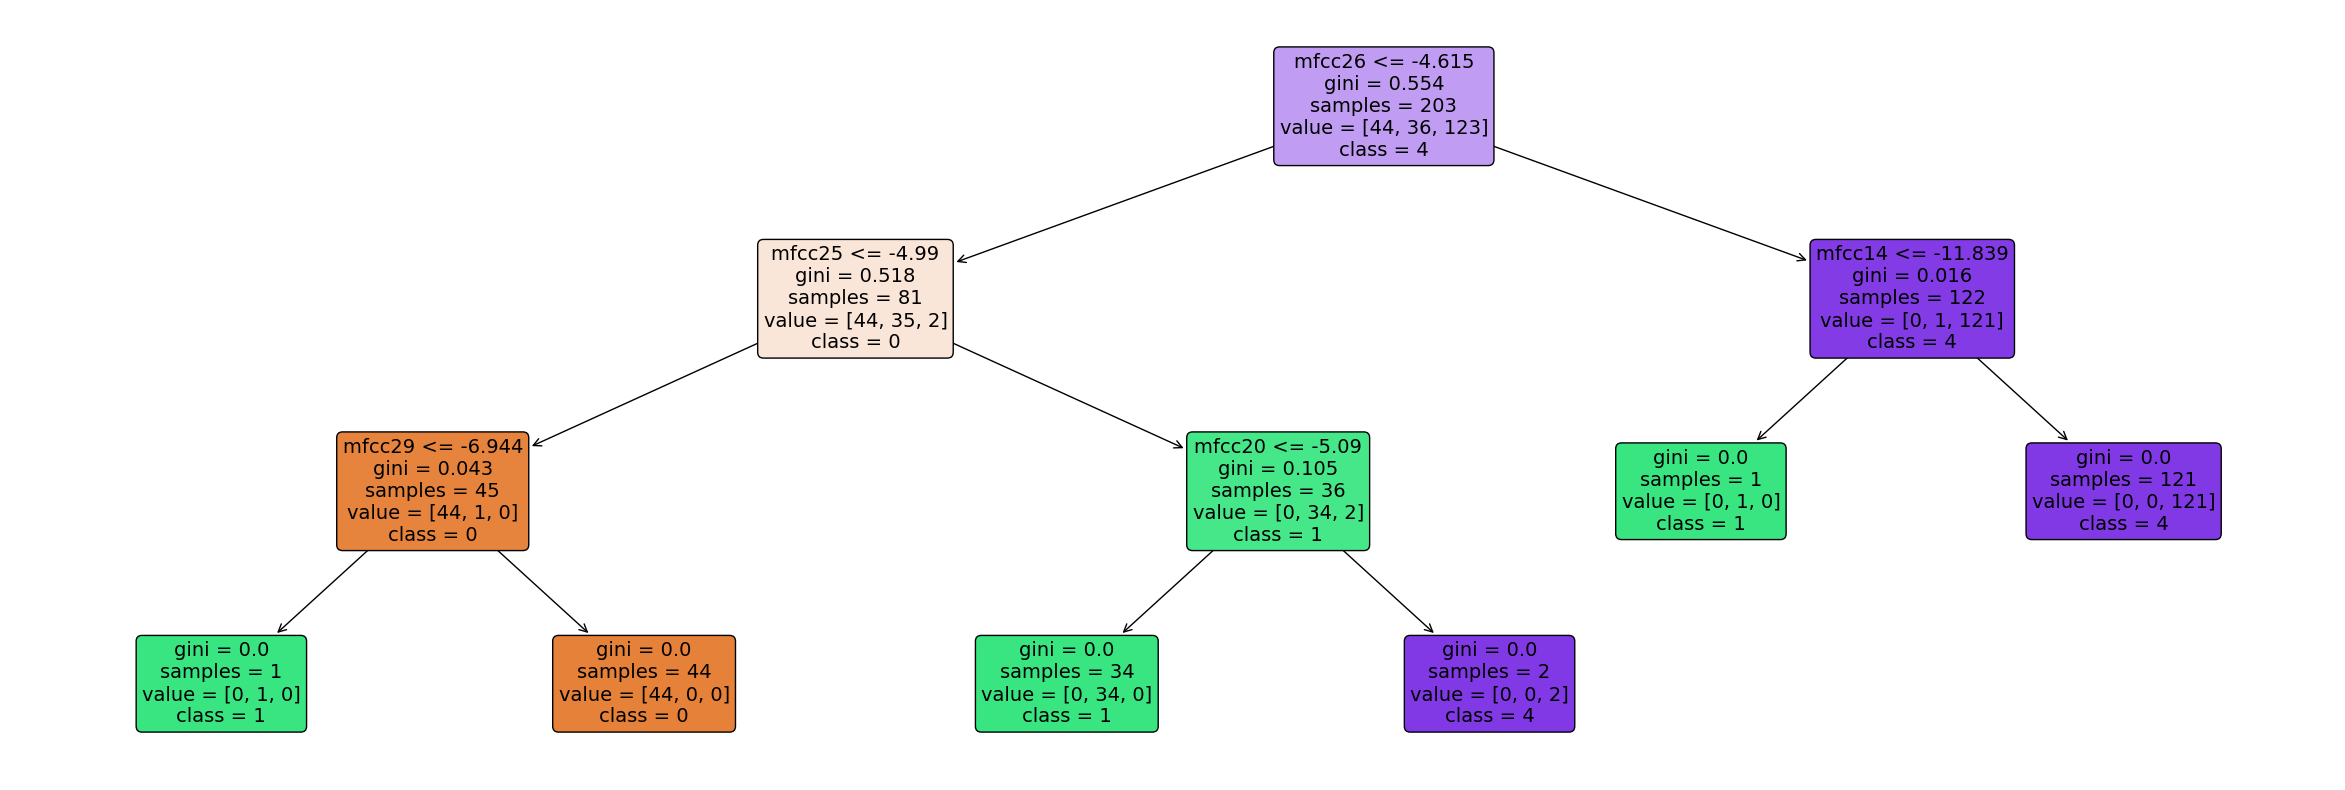

In [310]:
#plt the figure, setting a black background
plt.figure(figsize=(30,10))
#create the tree plot
a = tree.plot_tree(dtr1,feature_names = list(['rmse', 'spectral_centroid', 'spectral_bandwidth', 
                   'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 
                   'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 
                   'mfcc20', 'mfcc21', 'mfcc22', 'mfcc23', 'mfcc24', 'mfcc25', 'mfcc26', 'mfcc27', 'mfcc28', 'mfcc29', 'mfcc30', 
                   'mfcc31', 'mfcc32', 'mfcc33', 'mfcc34', 'mfcc35', 'mfcc36', 'mfcc37', 'mfcc38', 'mfcc39', 'mfcc40']),
                   class_names = ["0", "1","4"],
                   rounded = True,
                   filled = True,
                   fontsize=14)
#show the plot
plt.show()

In [311]:
# data = preProcessData('Speaker_File.csv')
test_pred_decision_tree = dtr1.predict(X_test)

print(test_pred_decision_tree)
print(np.array(y_test))


[1 3 3 3 1 3 3 3 3 3 1 0 3 3 3 3 3 3 3 3 1 3 0 1 3 1 3 3 1 3 3 3 1 0 3 0 3
 3 3 3 3 3 0 3 1 1 3 3 3 0 0 3 1 0 1 3 3 3 0 0 1 0 1 1 3 3 3 1]
[1 3 3 3 1 3 3 3 3 3 1 0 3 3 3 3 3 3 3 3 1 3 0 1 3 1 3 3 1 3 3 3 0 0 3 0 3
 3 3 3 3 3 0 3 1 1 3 3 3 0 0 3 1 0 0 3 3 3 0 0 1 0 1 1 3 3 3 1]


In [312]:
y_test=y_test.astype('int64')

print("Accuracy:",metrics.accuracy_score(y_test, test_pred_decision_tree))

Accuracy: 0.9705882352941176


In [313]:
def report(X_data, y_data):
    #Confution Matrix and Classification Report
    Y_pred = dtr1.predict(X_data)
    y_test_num = y_data.astype(np.int64)
    conf_mt = confusion_matrix(y_test_num, Y_pred)
    print(conf_mt)
    plt.matshow(conf_mt)
    plt.show()
    print('\nClassification Report')
    # target_names = ["Marina", "Mohab", "Unknown"]
    print(classification_report(y_test_num, Y_pred))

Classification Report for Test Data

[[11  2  0]
 [ 0 14  0]
 [ 0  0 41]]


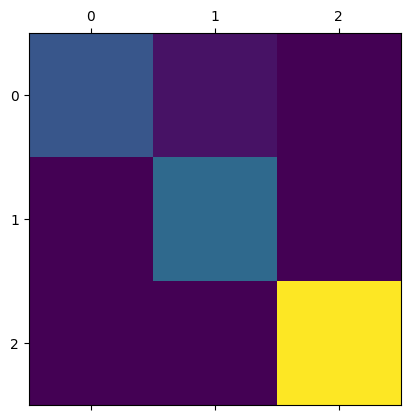


Classification Report
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       0.88      1.00      0.93        14
           3       1.00      1.00      1.00        41

    accuracy                           0.97        68
   macro avg       0.96      0.95      0.95        68
weighted avg       0.97      0.97      0.97        68



In [314]:
print("Classification Report for Test Data\n")
report(X_test, y_test)

In [315]:
# save the model to disk
import pickle
filename = 'final_model_test.sav'
pickle.dump(dtr1, open(filename, 'wb'))


# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [294]:
loaded_model =pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
result

1.0